STUDENT: JOAN ROSSELLO BOVER

In [1]:
import numpy as np
import scipy as sp
from scipy import io
import cv2 as cv 
import matplotlib.pyplot as plt
import pylab
import os # for reading all files in a folder
pylab.rcParams['figure.figsize'] = (12.0, 10.0)

# Condensation 9c

You'll have to call the code below four times (once each with 'll','lr', 'ul', 'ur': lower left, lower right, upper left, upper right). For each time you'll get an estimated track (2D locations over time) of one of the corners of the pattern moved. 

Note that we're saving off the single MAP estimate at each frame, but the particles in the Particle Filter are attempting to keep track of the whole posterior distribution. - i.e. the particles show the distribution of the template (in what areas of the image it matches the most), and the MAP is the single particle that has the highest probability in the distribution, and hence, the particle that corresponds to the highest match of the template with the image --> the location where the template is most probably found in the image (highest match --> the actual corner). So for each frame, we store the location in the image with the highest match with the template (i.e. we are storing the 2D coordinates of each corner in every frame, as time passes by and as the camera changes position - so we can see how the corners move position in the image through time).

Note: we have 151 frames.

Most TO DO parts below should be copy-paste from Practical9a and Practical9b.

computeLikelihood has been modified from its previous versions to cope with these particular gray-scale images.


Qustions you could ask yourself: 
- Can you find a pattern between the movement of the particles and the movement of the camera relative to the scene?

- - The particles move towards the corners (templates we are trying to identify). So if the camera moves away from a corner, then the particles will move in the opposite direction of the camera, following that corner. For example, if we move the camera south west, the top right corner in the image moves north east, and so will the partcles tracking the top right corner. 

- When is the MAP estimate especially good/bad?

- - The MAP estimate is especially good when the frame corresponds to a time when the camera was still, the image is clear and the particle filter can spot the corner with more accuracy. When the camera moves, the image is blurry and the corner occupies a larger range of pixels.

- - The MAP estimate is better when the frame corresponds to an angle of the camera that results in the same corner shape as the template. From some perspectives when the camera moves, the corner that the template is looking in the image for has a different angle than our template and hence the MAP estimate is not as spot on.

- - In the early frames, sometimes the MAP estimate is completely wrong, corresponding to some other part of the image and not the corner in question, but that is because the particle filter hasn't had time to converge yet and attribute weight to the adequate particles (i.e. there are no particles near the appropriate corner yet, and so the MAP estimate is just the particle that has the highest likelihood from the ones available, even though none of them are very accurate).

- What is the relationship to the amount of noise? (--> experiment with different levels!)

- - If noise is too small (i.e. std = 1), then the new particles will be very close to the old particles and the algortihm will converge very slowly. Moreover, if we are unlucky and on an iteration when we select the particles to propagate, we don't select any of the particles near the object we want to track (even if they ahve large weight), then the model will have deviated from the right solution and it will converge to something else.

- - If noise is too large, it's like we're initialising the particles randomly in every iteration and the fact that we'll find the appropriate MAP will depend on whether any of those particles will land on the object we want to track or not, because the presence of large noise makes the new particles be placed far away from the old particles that had high likelihood.

- - We need to find a level of noise that is in between, allows the particle filter to converge, but it doesn't limit itself to the current particles.

- Why do different numbers of particles lead to very differenet results (for example 50 vs. 2000)? 

- - The solution with a low number of particles is extremely dependent on the initial conditions (i.e. the initial random particles that are generated). If none of the initial particles happen to be near the corner we are trying to identify, the particle filter will never converge towards the corner because there are simply no particles near the corner to which we can give large weights, so the solution will converge to the position of whatever particle happens to give the highest likelihood, even if that likelihood is quite low (because the high likelihood that we would obtain if a particle were near the corner in question never comes into play and so it cannot eclipse the wrong predictions).
        
- - The more particles we have, the highest the probability that some of the starting particles will be close to the object we want to identify and the more probability we have that the particle filter will evolve towards that object and we'll get an accurate result.

In [2]:
#Likelihood function is simple patch similarity

def computeLikelihood(image, template):
    #opencv's available methods - experiment with these
    #careful what range the output is!
    methods = [cv.TM_CCOEFF, cv.TM_CCOEFF_NORMED, cv.TM_CCORR,
            cv.TM_CCORR_NORMED, cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]
    
    # likelihood = cv.matchTemplate(image[:,:,2], template, methods[0])
    # (You can also try converting the image to greyscale instead of using the third channel as above with 
    # cv.cvtColor(image, cv.COLOR_BGR2GRAY))
    likelihood = cv.matchTemplate(image, template, methods[0]) # images have been converted to greyscale
    
    #we can pad to make this the size of the input image (for easier indexing)   
    pad_first = int(template.shape[0])
    pad_second = int(template.shape[1])
    pad_amounts = ((0, pad_first-1), (0, pad_second-1))
    likelihood = np.pad(likelihood, pad_amounts, 'constant')
    likelihood[likelihood<0] = 0 # to avoid negative weights 
    
    # apply a 10x10 averaging filter for stability. You can experiment with different sizes. 
    kernel = np.ones((10,10),np.float32)/100
    smoothed = cv.filter2D(likelihood,-1,kernel) 
    return smoothed 

In [3]:

def HW2_Practical9c(corner):
    template = sp.io.loadmat(corner+'.mat')['pixelsTemplate']
    #let's show the template
    print('We are matching this template with shape: ', template.shape)
    plt.imshow(template)
    plt.show()

    # Load all images in folder
    images = []
    iFrame = 0
    folder = 'Pattern01/'
    lst = os.listdir(folder)
    lst.sort()

    for frameNum in lst:
        images.append(cv.cvtColor(cv.imread(folder+frameNum), cv.COLOR_BGR2GRAY)) # convert images to greyscale
        iFrame += 1
    # plot first image 
    plt.imshow(images[0])
    plt.show()

    imgHeight, imgWidth = images[0].shape
    numParticles = 2000
    weight_of_samples = np.ones((numParticles,1))

    # TO DO: normalize the weights (may be trivial this time) [done]
    weight_of_samples = weight_of_samples / np.sum(weight_of_samples) #replace this 

    # Initialize which samples from "last time" we want to propagate: all of
    # them!:
    samples_to_propagate = range(0, numParticles)


    # ============================
    # NOT A TO DO: You don't need to change the code below, but eventually you may
    # want to vary the number of Dims (compare for example to lab 9b) 
    numDims_w = 2
    # Here we randomly initialize some particles throughout the space of w:
    particles_old = np.random.rand(numParticles, numDims_w)
    particles_old[:,0] = particles_old[:,0] * imgHeight
    particles_old[:,1] = particles_old[:,1] * imgWidth
    # ============================


    #Initialize a temporary array r to store the per-frame MAP estimate of w. This is what we'll return in the end.
    r = np.zeros((iFrame, numDims_w))

    for iTime in range(iFrame):
        if iTime == 0 or iTime == 1 or iTime == 5 or iTime == 50 or iTime == 100 or iTime == iFrame-1: # only plot a few frames
            print('Processing Frame', iTime)
        # TO DO: compute the cumulative sume of the weights. [done]
        cum_hist_of_weights = np.cumsum(weight_of_samples, axis=0) # replace this
        #print(weight_of_samples)


        # ==============================================================
        # Resample the old distribution at time t-1, and select samples, favoring
        # those that had a higher posterior probability.
        # ==============================================================
        samples_to_propagate = np.zeros(numParticles, dtype=np.int32)

        # Pick random thresholds in the cumulative probability's range [0,1]:
        some_threshes = np.random.rand(numParticles)


        # For each random threshold, find which sample in the ordered set is
        # the first one to push the cumulative probability above that
        # threshold, e.g. if the cumulative histogram goes from 0.23 to 0.26
        # between the 17th and 18th samples in the old distribution, and the
        # threshold is 0.234, then we'll want to propagate the 18th sample's w
        # (i.e. particle #18).

        for sampNum in range(numParticles): 
            thresh = some_threshes[sampNum]
            for index in range (numParticles):
                if cum_hist_of_weights[index] > thresh:
                    break
            samples_to_propagate[sampNum] = index

        # Note: it's ok if some of the old particles get picked repeatedly, while
        # others don't get picked at all.


        # =================================================
        # Visualize if you want
        # =================================================
        #plt.title('Cumulative histogram of probabilities for sorted list of particles')
        #plt.plot(np.zeros(numParticles), some_threshes,'b.')
        #plt.plot(range(0, numParticles), cum_hist_of_weights, 'rx-')
        #which_sample_ids = np.unique(samples_to_propagate)
        #how_many_of_each = np.bincount(np.ravel(samples_to_propagate))
        #for k in range(len(which_sample_ids)):
        #    plt.plot(which_sample_ids[k], 0, 'bo-', markersize = 3 * how_many_of_each[k], markerfacecolor='white')
        #plt.xlabel('Indeces of all available samples, with larger blue circles for frequently re-sampled particles\n(Iteration %01d)' % iTime)
        #plt.ylabel('Cumulative probability');
        #plt.show()
        # =================================================
        # =================================================

        # Predict where the particles we sampled from the old distribution of 
        # state-space will go in the next time-step. This means we have to apply 
        # the motion model to each old sample.
        particles_new = np.zeros_like(particles_old)
        particles_old = particles_old[samples_to_propagate,:]
        for particleNum in range(numParticles):
            # TO DO: Incorporate some noise, e.g. Gaussian noise with std 20,
            # into the current location (particles_old), to give a Brownian
            # motion model.
            particles_new[particleNum, :] =  particles_old[particleNum, :] + np.random.normal(0, 20, particles_old.shape[1]) # replace this 
            
        # TO DO: Not initially, but change the motion model above to have
        # different degrees of freedom, and optionally completely different
        # motion models. See Extra Credit for more instructions.

        #calculate likelihood function
        likelihood = computeLikelihood(images[iTime], template)

        #plot results
        if iTime == 0 or iTime == 1 or iTime == 5 or iTime == 50 or iTime == 100 or iTime == iFrame-1: # only plot a few frames
            f, axarr = plt.subplots(1, 2)
            axarr[0].imshow(images[iTime])
            axarr[0].set_title('Particles')
            # now draw the particles onto the image
            axarr[0].plot(particles_new[:,1]+template.shape[1]/2, particles_new[:,0]+template.shape[0]/2, 'rx')

            #plot the likelihood
            axarr[1].imshow(likelihood)
            axarr[1].set_title('Likelihood')





        # From here we incorporate the data for the new state (time t):
        # The new particles accompanying predicted locations in state-space
        # for time t, are missing their weights: how well does each particle
        # explain the observations x_t?
        for particleNum in range(numParticles):

            # Convert the particle from state-space w to measurement-space x:
            # Note: that step is trivial here since both are in 2D space of image
            # coordinates

            # Within the loop, we evaluate the likelihood of each particle:
            particle = particles_new[particleNum, :]
            # Check that the predicted location is a place we can really evaluate
            # the likelihood.
            inFrame = particle[0] >= 0.0 and  particle[0] <= imgHeight and particle[1] >= 0.0 and particle[1] <= imgWidth
            if inFrame:
                minX = particle[1]
                minY = particle[0]

                weight_of_samples[particleNum] = likelihood[int(minY), int(minX)]

            else:
                weight_of_samples[particleNum] = 0.0

        # TO DO: normalize the weights [done]
        weight_of_samples = weight_of_samples / np.sum(weight_of_samples) # replace this
        
        # find the location of the particle with highest weight
        indices = np.argsort(weight_of_samples,0)
        bestScoringParticles = particles_new[np.squeeze(indices[-15:]), :]
        if iTime == 0 or iTime == 1 or iTime == 5 or iTime == 50 or iTime == 100 or iTime == iFrame-1: # only plot a few frames
            axarr[1].plot(bestScoringParticles[-1:,1], bestScoringParticles[-1:,0], 'rx')
        # Return the MAP of middle position. Add template.shape/2 because matchTemplate finds the position of the upper left corner 
        # of the template. We want to plot the centre of the template - i.e. where the corner we want to identify is.
        # This is the single best scoring particle at position -1 in argsort.
        r[iTime,:] = bestScoringParticles[-1,1]+template.shape[1]/2,bestScoringParticles[-1,0]+template.shape[0]/2
        if iTime == 0 or iTime == 1 or iTime == 5 or iTime == 50 or iTime == 100 or iTime == iFrame-1: # only plot a few frames
            print(r[iTime,:])   
            plt.show()
        # note that here we are just approximating where the corner is within the template. but it's not exactly at the centre of the
        # template. that's why the 'x' might not be spot on the corner in our plots, but they will be at the position matching
        # the middle of the template.

        #print the original image and the position of the tracked corner (MAP).
        if iTime == 0 or iTime == 1 or iTime == 5 or iTime == 50 or iTime == 100 or iTime == iFrame-1: # only plot a few frames
            plt.imshow(images[iTime])
            plt.plot(r[iTime,0],r[iTime,1],'rx')
            plt.show()
        # Now we're done updating the state for time t. 
        # For Condensation, just clean up and prepare for the next round of 
        # predictions and measurements:
        particles_old = particles_new

    return r

We are matching this template with shape:  (25, 28)


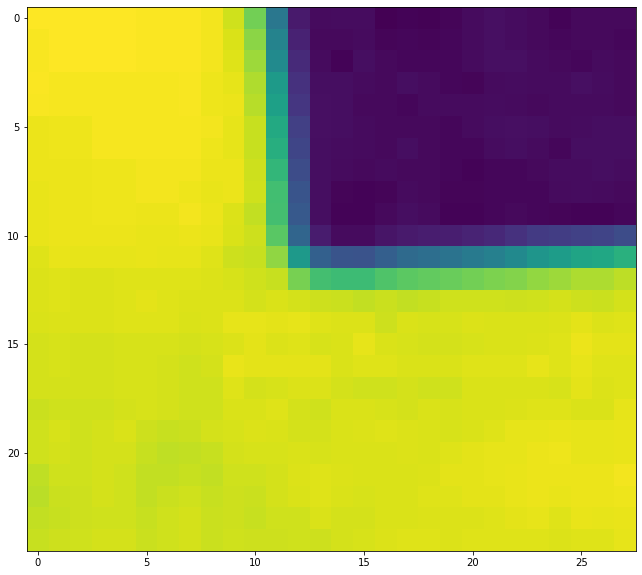

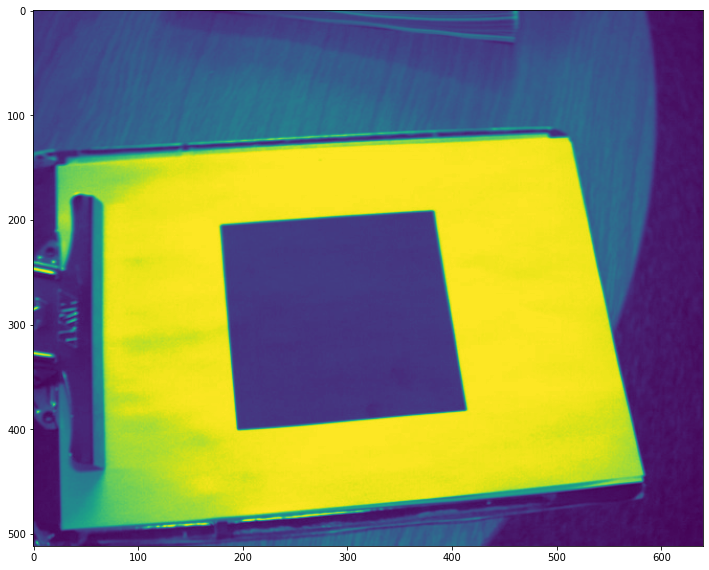

Processing Frame 0
[205.57169941 398.63614787]


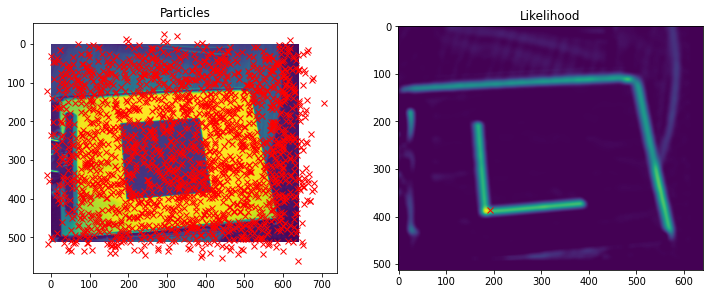

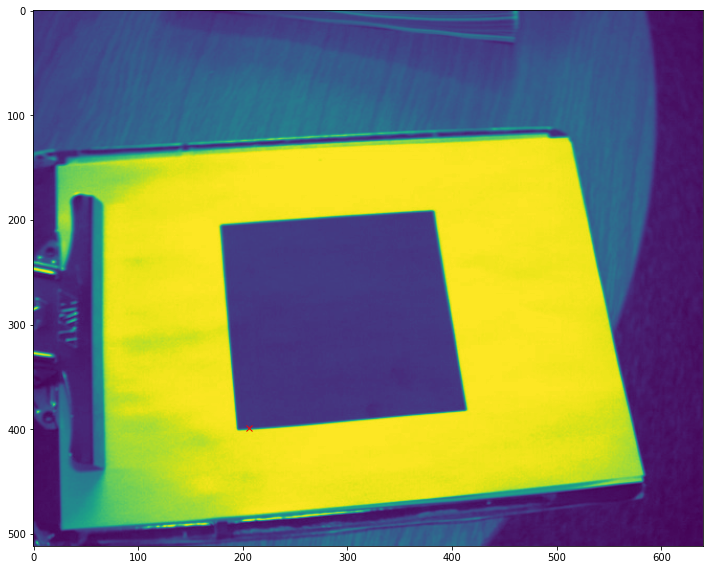

Processing Frame 1
[203.55407932 399.28076703]


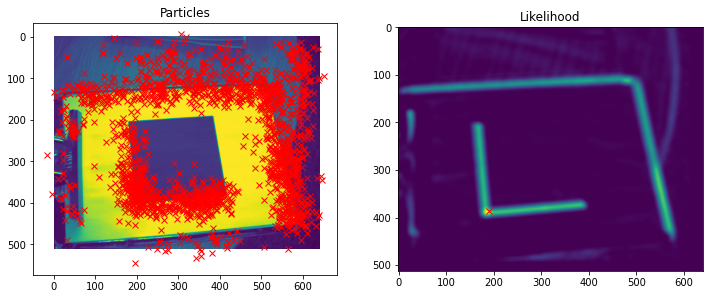

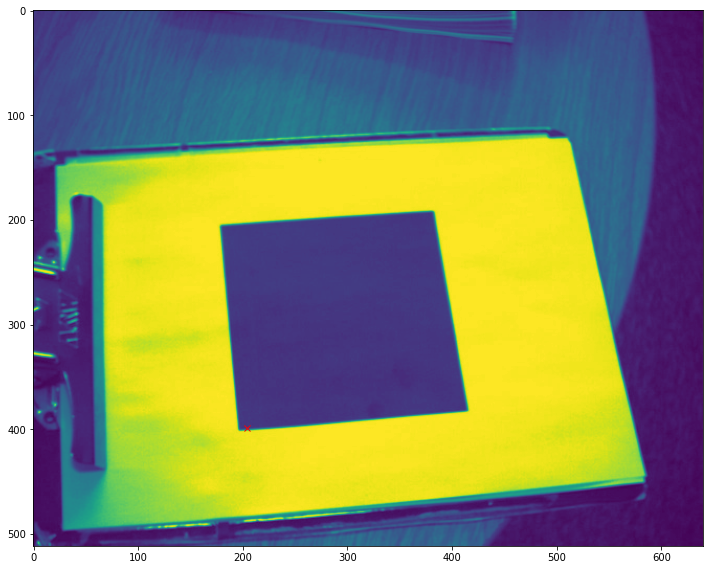

Processing Frame 5
[205.10535394 402.44695263]


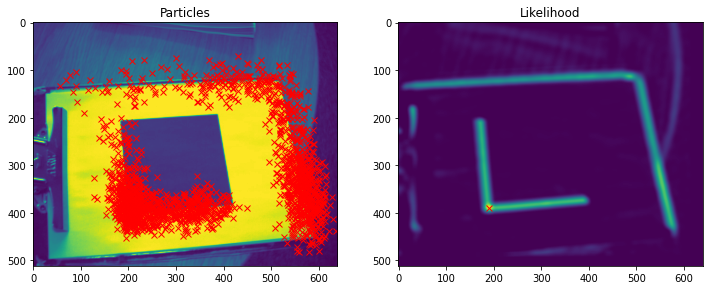

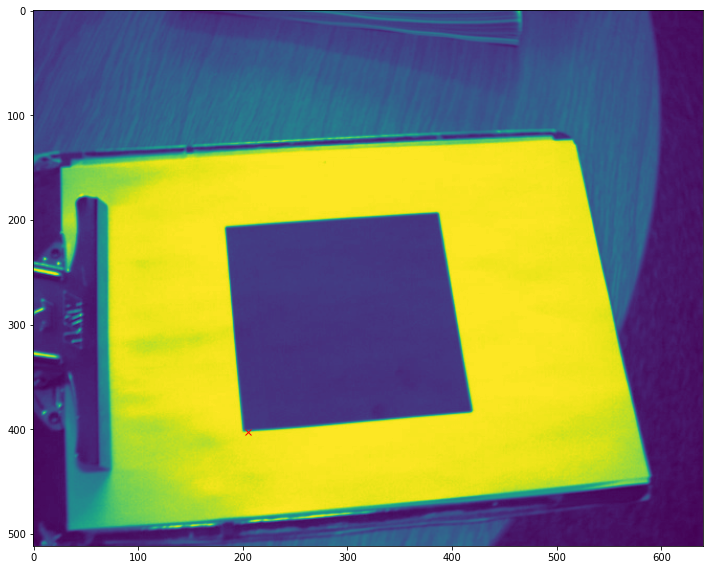

Processing Frame 50
[176.32750819 463.94099945]


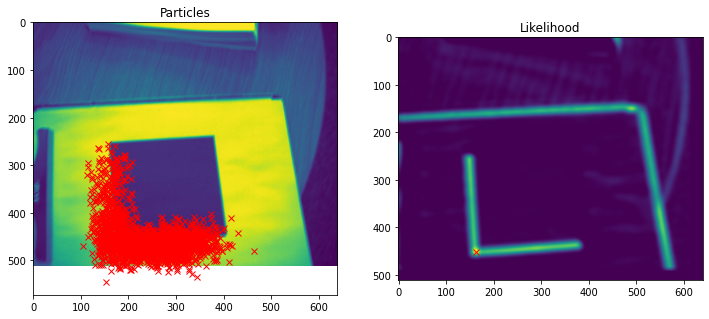

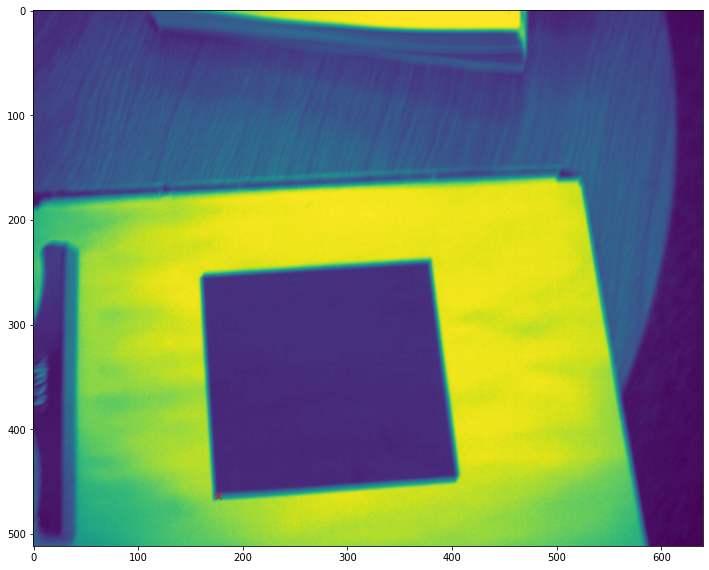

Processing Frame 100
[177.56945434 364.06816561]


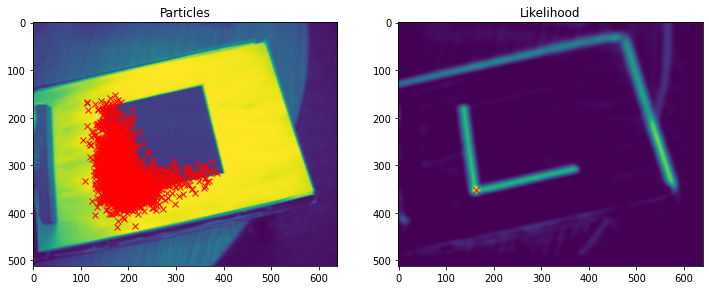

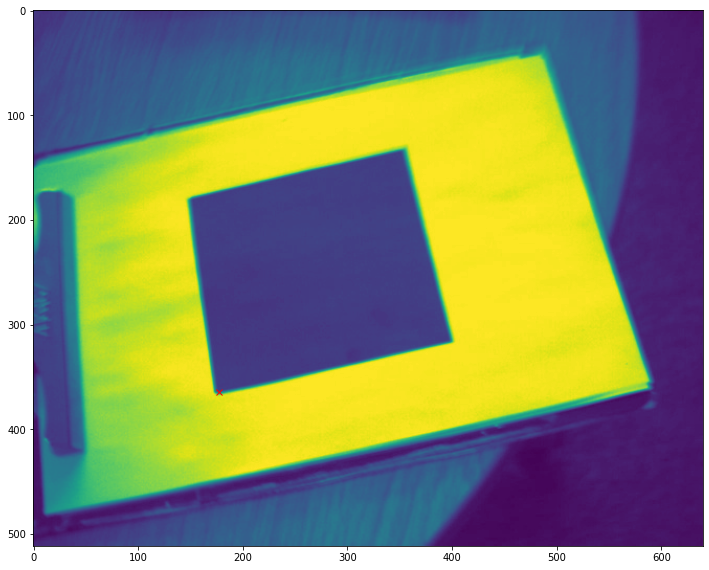

Processing Frame 150
[169.64557086 312.86131693]


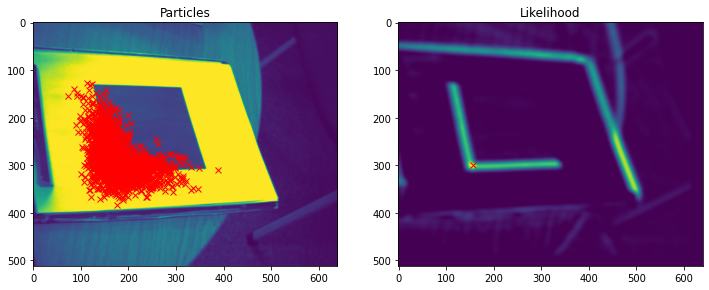

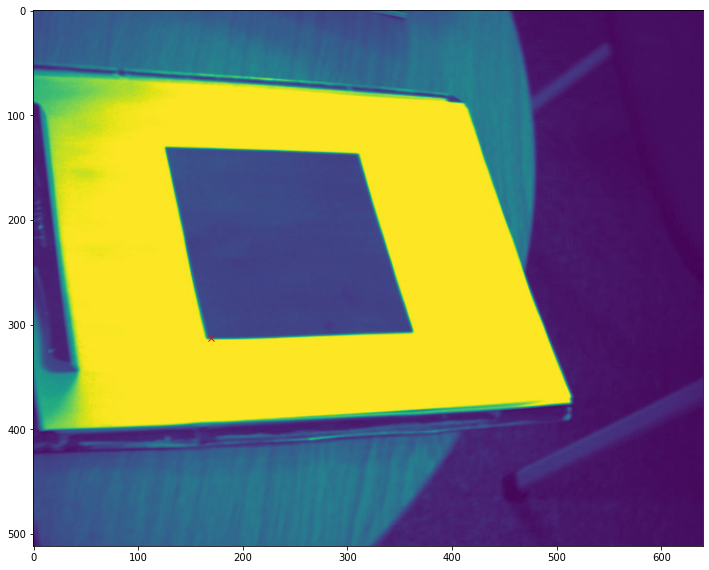

In [4]:
r = HW2_Practical9c('ll')

Note: most of the interesting points we can talk about in this section have already been talked about at the beginning of this notebook. See bullet points under "Questions you could ask yourself".

Looking at the frames we have plotted, we can see that the particle filter succeeds in tracking the corners of the square (in this case the lower left corner). In the early frames it is not too accurate because the particle filter needs to converge, but with more iterations, in the later frames, the tracking of the corner seems very accurate despite the large movements of the camera - we can see that the position and shape of the square in the image between frames 50, 100 and 150 are completely different (as a result of the camera movement), but the particle filter still manages to identify the lower left corner precisely.